# Project 2 – Titanic: Inspect, Explore, Split  
**Name:** Blessing Aganaga  
**Date:** October 29, 2025  

This project explores the Titanic dataset using the same structured process as the Lab 2 Howell example.  
We inspect, visualize, clean, and engineer data features, then compare a basic vs. stratified train/test split to prepare the data for modeling.


In [130]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit


## Section 1: Import and Inspect the Data

### Load and Quick Look


In [131]:
# Load the Titanic dataset from seaborn
import seaborn as sns
titanic = sns.load_dataset('titanic')

# Basic inspection
titanic.info()
print("\nFirst 10 rows:")
print(titanic.head(10))

print("\nMissing values per column:")
print(titanic.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB

First 10 rows:
   survived  pclass     sex   age  sibsp  parch     fare embark

In [132]:
# Summary statistics (numeric only)
print(titanic.select_dtypes(include='number').describe())

# Correlations (numeric only)
print(titanic.select_dtypes(include='number').corr())




         survived      pclass         age       sibsp       parch        fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200
          survived    pclass       age     sibsp     parch      fare
survived  1.000000 -0.338481 -0.077221 -0.035322  0.081629  0.257307
pclass   -0.338481  1.000000 -0.369226  0.083081  0.018443 -0.549500
age      -0.077221 -0.369226  1.000000 -0.308247 -0.189119  0.096067
sibsp    -0.035322  0.

In [133]:
n_rows = len(titanic)
n_cols = titanic.shape[1]
columns = titanic.columns.tolist()
non_numeric = titanic.select_dtypes(exclude='number').columns.tolist()
age_summary = titanic['age'].agg(['min','median','max'])
print(f"Instances: {n_rows}, Features: {n_cols}")
print("Column names:", columns)
print("Non-numeric columns:", non_numeric)
print("Age summary (min/median/max):")
print(age_summary)


Instances: 891, Features: 15
Column names: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']
Non-numeric columns: ['sex', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']
Age summary (min/median/max):
min        0.42
median    28.00
max       80.00
Name: age, dtype: float64


## Section 2 – Explore and Prepare the Data


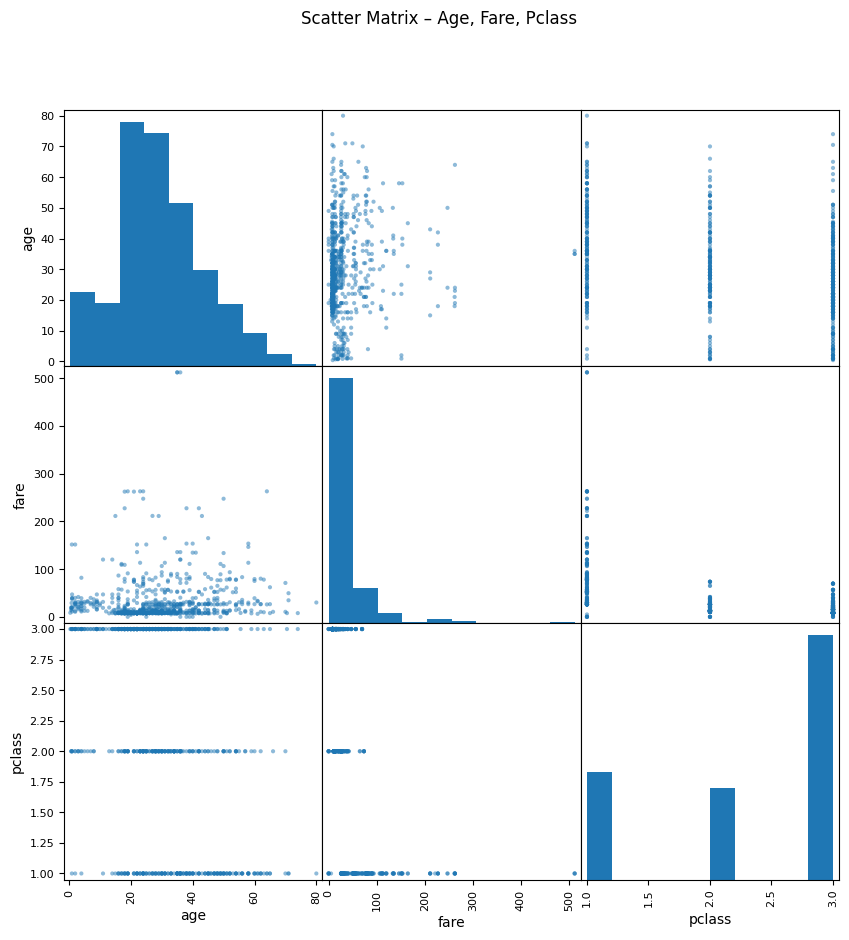

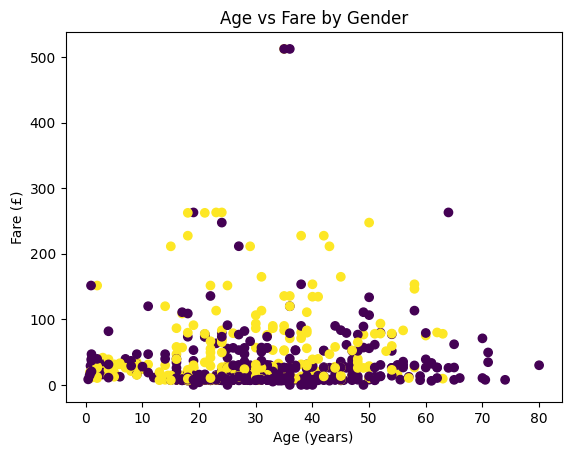

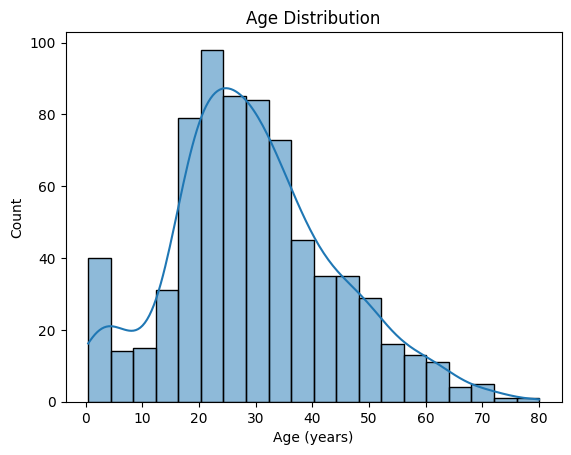

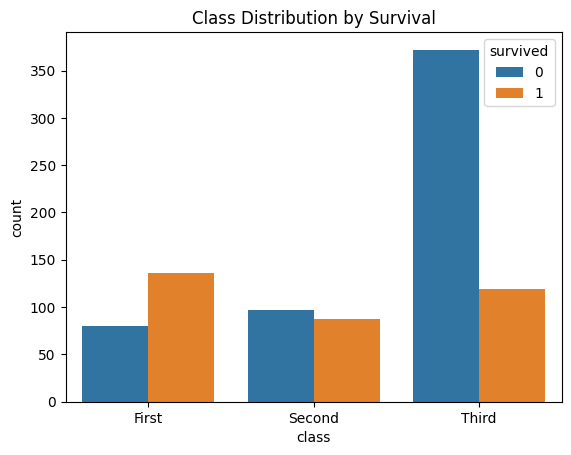

In [134]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter matrix of numeric features
attributes = ['age','fare','pclass']
scatter_matrix(titanic[attributes], figsize=(10,10))
plt.suptitle('Scatter Matrix – Age, Fare, Pclass')
plt.show()

# Scatter plot of Age vs Fare colored by gender
sex_color = titanic['sex'].apply(lambda x: 0 if x=='male' else 1)
plt.scatter(titanic['age'], titanic['fare'], c=sex_color)
plt.xlabel('Age (years)')
plt.ylabel('Fare (£)')
plt.title('Age vs Fare by Gender')
plt.show()

# Age Histogram
sns.histplot(titanic['age'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.show()

# Class Distribution by Survival
sns.countplot(x='class', hue='survived', data=titanic)
plt.title('Class Distribution by Survival')
plt.show()


### Reflection 2.1
- Patterns or anomalies noticed: (e.g., younger passengers tended to pay less fare; higher fares in 1st class)  
- Features that look predictive: class, fare, sex, and age seem important for survival.  
- Visible class imbalance or skews: more 3rd class passengers than 1st/2nd; survival rate lower in 3rd class.


In [135]:
# Replace missing values safely (no warnings)
titanic['age'] = titanic['age'].fillna(titanic['age'].median())
titanic['embark_town'] = titanic['embark_town'].fillna(titanic['embark_town'].mode()[0])

if titanic['embarked'].isna().any():
    titanic['embarked'] = titanic['embarked'].fillna(titanic['embarked'].mode()[0])



In [136]:
# Add Family Size
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# Convert categorical to numeric
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# Ensure 'alone' is binary
titanic['alone'] = titanic['alone'].astype(int)

# Optional: Add child flag
titanic['is_child'] = (titanic['age'] < 18).astype(int)

# Preview
titanic.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,family_size,is_child
0,0,3,0,22.0,1,0,7.2500,2,Third,man,True,NaN,Southampton,no,0,2,0
1,1,1,1,38.0,1,0,71.2833,0,First,woman,False,C,Cherbourg,yes,0,2,0
2,1,3,1,26.0,0,0,7.9250,2,Third,woman,False,NaN,Southampton,yes,1,1,0
3,1,1,1,35.0,1,0,53.1000,2,First,woman,False,C,Southampton,yes,0,2,0
4,0,3,0,35.0,0,0,8.0500,2,Third,man,True,NaN,Southampton,no,1,1,0


### Reflection 2.3
- Why family size is useful: larger families might stay together and impact survival probability.  
- Why convert categoricals to numeric: machine learning models require numeric inputs for training and correlation analysis.  


## Section 3 – Feature Selection and Target


In [137]:
# Select features (X) and target (y)
features = ['age', 'fare', 'pclass', 'sex', 'family_size']
target = 'survived'

X = titanic[features].copy()
y = titanic[target].astype(int)

# Check for missing values in selected features
print(X.isnull().sum())
X.head()


age            0
fare           0
pclass         0
sex            0
family_size    0
dtype: int64


,age,fare,pclass,sex,family_size
0,22.0,7.2500,3,0,2
1,38.0,71.2833,1,1,2
2,26.0,7.9250,3,1,1
3,35.0,53.1000,1,1,2
4,35.0,8.0500,3,0,1


### Reflection 3
- **Why these features were selected:** They capture passenger demographics (age, sex), socio-economic class (pclass, fare), and family context (family_size) — all likely relevant to survival.
- **Most predictive features:** Sex and class are expected to be the strongest predictors since women and first-class passengers had higher survival rates.


## Section 4 – Split and Compare (Basic vs. Stratified)


In [138]:
import numpy as np

def show_ratio_binary(series, positive_value=1, label_pos="Survived", label_neg="Not Survived"):
    frac_pos = (series == positive_value).mean()
    frac_neg = 1 - frac_pos
    ratio = np.nan if frac_neg == 0 else frac_pos / frac_neg
    print(f"{label_pos}: {frac_pos:.3f}, {label_neg}: {frac_neg:.3f}, Ratio: {ratio:.3f}")


In [139]:
from sklearn.model_selection import train_test_split

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X, y, test_size=0.2, random_state=123
)

print("Basic Split:")
print(f"Train size: {len(X_train_b)}, Test size: {len(X_test_b)}")

print("\nOriginal survived distribution:")
print(y.value_counts(normalize=True).round(3))

print("\nTrain survived distribution:")
print(y_train_b.value_counts(normalize=True).round(3))

print("\nTest survived distribution:")
print(y_test_b.value_counts(normalize=True).round(3))

print("\nRatios (Survived / Not-survived):")
print("Original:", end=" "); show_ratio_binary(y)
print("Train   :", end=" "); show_ratio_binary(y_train_b)
print("Test    :", end=" "); show_ratio_binary(y_test_b)


Basic Split:
Train size: 712, Test size: 179

Original survived distribution:
survived
0    0.616
1    0.384
Name: proportion, dtype: float64

Train survived distribution:
survived
0    0.611
1    0.389
Name: proportion, dtype: float64

Test survived distribution:
survived
0    0.637
1    0.363
Name: proportion, dtype: float64

Ratios (Survived / Not-survived):
Original: Survived: 0.384, Not Survived: 0.616, Ratio: 0.623
Train   : Survived: 0.389, Not Survived: 0.611, Ratio: 0.637
Test    : Survived: 0.363, Not Survived: 0.637, Ratio: 0.570


In [140]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)

for train_idx, test_idx in sss.split(X, y):
    X_train_s = X.iloc[train_idx]
    X_test_s = X.iloc[test_idx]
    y_train_s = y.iloc[train_idx]
    y_test_s = y.iloc[test_idx]

print("\nStratified Split:")
print(f"Train size: {len(X_train_s)}, Test size: {len(X_test_s)}")

print("\nOriginal survived distribution:")
print(y.value_counts(normalize=True).round(3))

print("\nStratified train survived distribution:")
print(y_train_s.value_counts(normalize=True).round(3))

print("\nStratified test survived distribution:")
print(y_test_s.value_counts(normalize=True).round(3))

print("\nRatios (Survived / Not-survived):")
print("Original   :", end=" "); show_ratio_binary(y)
print("Train (str):", end=" "); show_ratio_binary(y_train_s)
print("Test  (str):", end=" "); show_ratio_binary(y_test_s)



Stratified Split:
Train size: 712, Test size: 179

Original survived distribution:
survived
0    0.616
1    0.384
Name: proportion, dtype: float64

Stratified train survived distribution:
survived
0    0.617
1    0.383
Name: proportion, dtype: float64

Stratified test survived distribution:
survived
0    0.615
1    0.385
Name: proportion, dtype: float64

Ratios (Survived / Not-survived):
Original   : Survived: 0.384, Not Survived: 0.616, Ratio: 0.623
Train (str): Survived: 0.383, Not Survived: 0.617, Ratio: 0.622
Test  (str): Survived: 0.385, Not Survived: 0.615, Ratio: 0.627


### Reflection 4
- **Why stratification improves performance:** It preserves the original class balance (e.g., same % of survivors), ensuring fair model evaluation.
- **How close are distributions:** Stratified split keeps survival ratios almost identical between training and testing sets.
- **Which method is better:** The stratified split is preferred for classification tasks with unbalanced classes.
- **When to use stratification:** Always for categorical target variables like survival, gender, or class to maintain equal representation.
